In [ ]:
import ast
import itertools
import multiprocessing
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from src.api.models.vector_index import FAISSIndexWithMetadata
from src.config import UNKNOWN_CLASS_ID
from torchvision.ops import box_iou, nms
from tqdm import tqdm

from controlled_experiment.prediction_utils import (
    calculate_metrics,
    create_confusion_matrix,
    create_per_class_metrics_df,
    render_confusion_matrix,
    update_confusion_matrix,
    evaluate_predictions,
)
from controlled_experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    MISSING_PREDICTION_CLASS_ID,
    TRIAL_RECORDING_UUIDS,
    OBJECT_DATASETS_PATH,
    FINAL_PREDICTIONS_PATH,
    VECTOR_INDEXES_PATH
)
from collections import defaultdict

In [2]:
GROUND_TRUTH_PATH = Path("data/ground_truth.csv")
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
ground_truth_df.head()

,recording_uuid,frame_idx,class_id,mask_area,laplacian_variance,x1,y1,x2,y2
0,67b71a70-da64-467a-9fb6-91bc29265fd1,223,1,5384,56.868510,1045,467,1107,567
1,67b71a70-da64-467a-9fb6-91bc29265fd1,42,1,1433,144.979676,645,451,679,498
2,67b71a70-da64-467a-9fb6-91bc29265fd1,86,1,1410,166.952593,665,437,698,485
3,67b71a70-da64-467a-9fb6-91bc29265fd1,242,1,8206,54.435912,902,449,978,572
4,67b71a70-da64-467a-9fb6-91bc29265fd1,21,1,1445,165.012037,642,450,676,498


In [3]:
def temporal_pooling_prediction(
    index: "FAISSIndexWithMetadata",
    object_df: pd.DataFrame,
    k: int,
    max_distance: float
) -> pd.DataFrame:
    """
    For each tracked object, compute a weighted average embedding, then perform
    a top-k search in the FAISS index and choose the class with the lowest
    average distance among the retrieved neighbors.
    
    Returns object_df (minus 'embedding') with added:
      - 'predicted_class_id'
      - 'prediction_confidence'
    """
    predictions = []

    for object_id, group in object_df.groupby("object_id"):
        # 1) Stack frame embeddings into a (N, d) FloatTensor
        emb_list = group["embedding"].apply(ast.literal_eval).tolist()
        embeddings = torch.tensor(emb_list, dtype=torch.float32)  # (N, d)

        # 2) Normalize mask_area to [0,1]
        mask = torch.tensor(group["mask_area"].astype(float).values, dtype=torch.float32)
        mask_norm = mask / mask.max() if mask.max() > 0 else torch.ones_like(mask)

        # 3) Detection confidence tensor
        conf = torch.tensor(group["confidence"].astype(float).values, dtype=torch.float32)

        # 4) Composite weights
        weights = mask_norm * conf  # (N,)

        # 5) Weighted average embedding
        weighted_sum = (embeddings * weights.unsqueeze(1)).sum(dim=0)
        total_w = weights.sum()
        agg_emb = weighted_sum / total_w if total_w > 0 else embeddings.mean(dim=0)

        # 6) Query FAISS with a (1, d) tensor
        query_tensor = agg_emb.unsqueeze(0)  # shape (1, d)
        distances, indices = index.search(query_tensor, k)  # tensors (1, k)
        metadata = index.get_metadatas(indices[0].tolist())
        class_ids = [m["class_id"] for m in metadata]
        dists = distances[0].tolist()

        # 7) Compute average distance per class
        dist_by_class = defaultdict(list)
        for cls, dist in zip(class_ids, dists):
            dist_by_class[cls].append(dist)
        avg_dist_by_class = {cls: sum(lsts)/len(lsts) for cls, lsts in dist_by_class.items()}

        # 8) Select class with lowest average distance
        best_cls, best_avg_dist = min(avg_dist_by_class.items(), key=lambda x: x[1])

        # 9) Thresholding for unknown
        if best_avg_dist > max_distance:
            pred_cls, pred_conf = UNKNOWN_CLASS_ID, 0.0
        else:
            pred_cls = best_cls
            pred_conf = float(max(0.0, 1.0 - (best_avg_dist / max_distance)))

        predictions.append({
            "object_id": object_id,
            "predicted_class_id": pred_cls,
            "prediction_confidence": pred_conf
        })

    # Merge predictions back into the DataFrame
    preds_df = pd.DataFrame(predictions)
    result_df = object_df.drop(columns=["embedding"]).merge(
        preds_df, on="object_id", how="left"
    )
    return result_df

In [ ]:
vector_indexes = {
    "same_background": {
        int(path.stem.split("_")[0]): FAISSIndexWithMetadata.load(path)
        for path in (VECTOR_INDEXES_PATH / "same_background").glob("*.index")
    },
    "diff_background": {
        int(path.stem.split("_")[0]): FAISSIndexWithMetadata.load(path)
        for path in (VECTOR_INDEXES_PATH / "diff_background").glob("*.index")
    },
}

labeling_sets = ["same_background"]
sample_counts = vector_indexes[labeling_sets[0]].keys()
sample_counts = [600]
k_values = [10, 20, 50, 100]
max_distance_values = [0.5]#, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
min_mask_area_sizes = [0]  # , 200, 400, 600, 800, 1000, 2000, 3000, 4000]

total_possibilities = (
    len(labeling_sets)
    * len(sample_counts)
    * len(k_values)
    * len(max_distance_values)
    * len(min_mask_area_sizes)
)
num_possibilities_tried = 0

In [5]:
def process_grid_combination(params):
    """
    Process a single grid combination.

    Parameters:
        params (tuple): A tuple (sample_count, k, confidence, min_mask_area_size)

    Returns:
        tuple: A tuple containing the grid_key, the confusion matrix, and the calculated metrics.
    """
    labeling_set, sample_count, k, max_distance, min_mask_area_size = params
    cm = create_confusion_matrix()
    index = vector_indexes[labeling_set][sample_count]
    dataset_paths = list(OBJECT_DATASETS_PATH.iterdir())
    for object_dataset_path in dataset_paths:
        trial_recording_uuid = object_dataset_path.stem
        object_df = pd.read_csv(object_dataset_path)

        predictions_df = temporal_pooling_prediction(
            index,
            object_df,
            k=k,
            max_distance=max_distance,
        )

        gt_df = ground_truth_df[
            ground_truth_df["recording_uuid"] == trial_recording_uuid
        ].copy()

        evaluation_df = evaluate_predictions(predictions_df, gt_df, iou_threshold=0.5)

        update_confusion_matrix(cm, evaluation_df)

    metrics = calculate_metrics(cm)
    return params, cm, metrics

In [6]:
params_list = list(
    itertools.product(
        labeling_sets, sample_counts, k_values, max_distance_values, min_mask_area_sizes
    )
)
total_possibilities = len(params_list)

print(f"Processing {total_possibilities} possibilities using multiprocessing...")

grid_search_confusion_matrices = {}
grid_search_metrics = {}

with multiprocessing.Pool() as pool:
    # imap_unordered yields results as soon as they’re ready
    for grid_key, cm, metrics in tqdm(
        pool.imap_unordered(process_grid_combination, params_list),
        total=total_possibilities,
        desc="Grid search",
    ):
        grid_search_confusion_matrices[grid_key] = cm
        grid_search_metrics[grid_key] = metrics

print("All done!")

Processing 4 possibilities using multiprocessing...


Grid search: 100%|██████████| 4/4 [00:20<00:00,  5.14s/it]

All done!


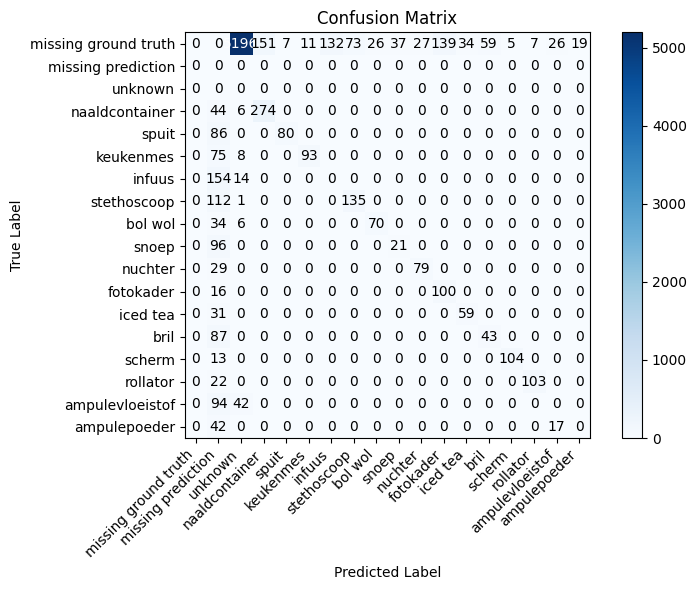

Best grid key: ('same_background', 600, 10, 0.5, 0)
Best metrics: {'overall_accuracy': 0.1426465167711021, 'micro': {'precision': 0.1426465167711021, 'recall': 0.1426465167711021, 'f1': 0.1426465167711021}, 'per_class': {-3: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 5949, 'unknown_rate': 0.8734241048915784}, -2: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 0, 'unknown_rate': 0.0}, -1: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 0, 'unknown_rate': 0.0}, 1: {'precision': 0.6447058823529411, 'recall': 0.845679012345679, 'f1': 0.7316421895861147, 'support': 324, 'unknown_rate': 0.018518518518518517}, 2: {'precision': 0.9195402298850575, 'recall': 0.4819277108433735, 'f1': 0.6324110671936759, 'support': 166, 'unknown_rate': 0.0}, 3: {'precision': 0.8942307692307693, 'recall': 0.5284090909090909, 'f1': 0.6642857142857143, 'support': 176, 'unknown_rate': 0.045454545454545456}, 4: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 168, 'unknown_rate': 

In [7]:
# Select the grid key with the highest overall F1 score.
best_key = max(
    grid_search_metrics, key=lambda key: grid_search_metrics[key]["micro"]["recall"]
)
best_metrics = grid_search_metrics[best_key]
best_confusion_matrix = grid_search_confusion_matrices[best_key]

render_confusion_matrix(best_confusion_matrix)

print(f"Best grid key: {best_key}")
print(f"Best metrics: {best_metrics}")


In [8]:
import pandas as pd

# Stel dat best_keys_df al is gedefinieerd zoals eerder:
best_keys_df = per_class_metrics_df.copy()
best_keys_df = best_keys_df.loc[best_keys_df.groupby("class_id")["f1"].idxmax()].copy()
best_keys_df["class_name"] = best_keys_df["class_id"].apply(
    lambda cid: CLASS_ID_TO_NAME.get(cid, cid)
)
best_keys_df.sort_values("class_name", inplace=True)

selected_columns = [
    "class_id",
    "class_name",
    "sample_count",
    "k",
    "confidence",
    "min_mask_area_size",
    "precision",
    "recall",
    "f1",
    "unknown_rate",
]

# Definieer kolom-breedtes
col_widths = {
    "class_id": 10,
    "class_name": 20,
    "sample_count": 15,
    "k": 5,
    "confidence": 12,
    "min_mask_area_size": 20,
    "precision": 10,
    "recall": 10,
    "f1": 10,
    "unknown_rate": 15,
}

# Maak een header
header = (
    f"{'class_id':<{col_widths['class_id']}} "
    f"{'class_name':<{col_widths['class_name']}} "
    f"{'sample_count':<{col_widths['sample_count']}} "
    f"{'k':<{col_widths['k']}} "
    f"{'confidence':<{col_widths['confidence']}} "
    f"{'min_mask_area_size':<{col_widths['min_mask_area_size']}} "
    f"{'precision':<{col_widths['precision']}} "
    f"{'recall':<{col_widths['recall']}} "
    f"{'f1':<{col_widths['f1']}}"
    f"{'unknown_rate':<{col_widths['unknown_rate']}} "
)

print(header)
print("-" * len(header))

# Print iedere rij volgens de kolom breedtes. Aangepast op floats met 3 decimalen.
for _, row in best_keys_df[selected_columns].iterrows():
    print(
        f"{row['class_id']!s:<{col_widths['class_id']}} "
        f"{row['class_name']!s:<{col_widths['class_name']}} "
        f"{row['sample_count']!s:<{col_widths['sample_count']}} "
        f"{row['k']!s:<{col_widths['k']}} "
        f"{row['confidence']!s:<{col_widths['confidence']}} "
        f"{row['min_mask_area_size']!s:<{col_widths['min_mask_area_size']}} "
        f"{row['precision']:<{col_widths['precision']}.3f} "
        f"{row['recall']:<{col_widths['recall']}.3f} "
        f"{row['f1']:<{col_widths['f1']}.3f}"
        f"{row['unknown_rate']:<{col_widths['unknown_rate']}.3f} "
    )

NameError: name 'per_class_metrics_df' is not defined